# 04. Pytorch Custom Datasets Video Notebook

## 0. Importing Pytorch and setting up device-agnostic code

In [232]:
import torch
from torch import nn

torch.__version__

'2.1.2'

In [233]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "5"

In [234]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [235]:
torch.cuda.device_count()

1

In [10]:
!nvidia-smi

Sat Jan  6 07:48:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:1D:00.0 Off |                  N/A |
| 30%   37C    P8               34W / 350W|      3MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

In [15]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [17]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [18]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 1 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 1 images in 'data/pizza_steak_sushi/train/steak/.ipynb_checkpoints'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [19]:
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

data/pizza_steak_sushi/train/steak/1225762.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/1225762.jpg
Image class: steak
Image height: 512
Image width: 289


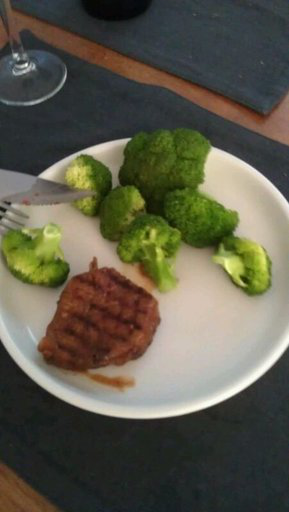

In [42]:
import random
from PIL import Image

#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

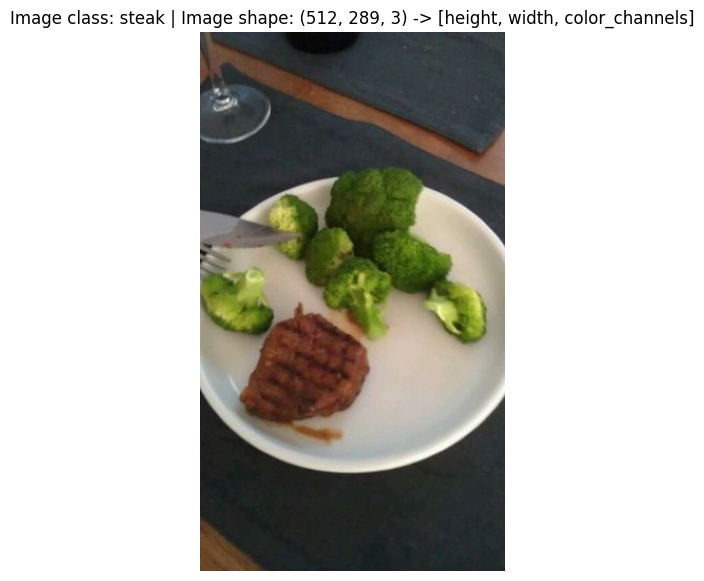

In [43]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

#plot the image with plt
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

In [45]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms

In [65]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [66]:
data_transform(img).dtype

torch.float32

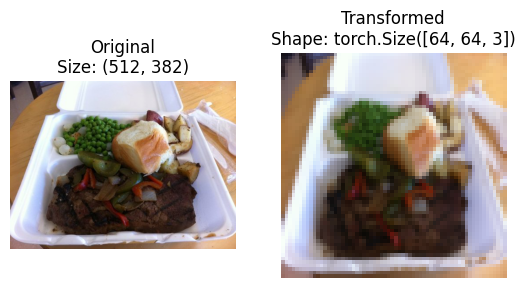

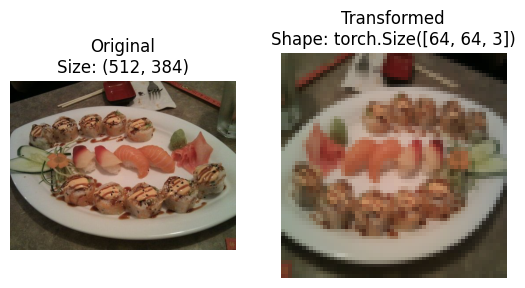

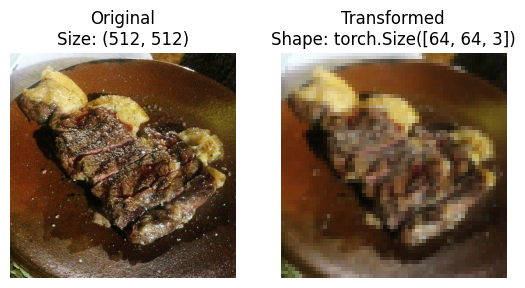

In [74]:
def plot_transformed_images(image_paths, transform, n =3, seed=42):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            #fig.suptitlte(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_paths=image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

In [76]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 226
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [77]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [78]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [79]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [80]:
len(train_data), len(test_data)

(226, 75)

In [82]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [88]:
img, label = train_data[0]

In [92]:
img.shape

torch.Size([3, 64, 64])

In [90]:
label

0

In [91]:
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

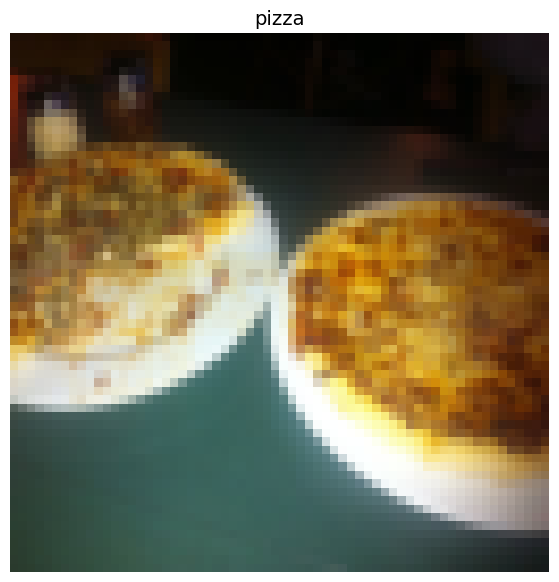

In [93]:
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 14)

## 4.1 Turn loaded images into `DataLoader`

In [95]:
!nvidia-smi

Sat Jan  6 12:25:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:1D:00.0 Off |                  N/A |
| 30%   37C    P8               34W / 350W|      3MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [96]:
import os
os.cpu_count()

64

In [110]:
from torch.utils.data import DataLoader
BATCH_SIZE =1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              num_workers= 1,
                             shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers=1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f450424b8e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4504249e70>)

In [111]:
len(train_dataloader), len(test_dataloader)

(226, 75)

In [112]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

In [114]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [115]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [117]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [120]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return  classes, class_to_idx

In [121]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [123]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform = None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [124]:
train_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [125]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [126]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f450449f070>,
 <__main__.ImageFolderCustom at 0x7f450449f850>)

In [127]:
train_data

Dataset ImageFolder
    Number of datapoints: 226
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [128]:
len(train_data), len(train_data_custom)

(226, 225)

In [129]:
len(test_data), len(test_data_custom)

(75, 75)

In [130]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [131]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [132]:
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

In [134]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n>10:
        n=10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k= n)

    plt.figure(figsize=(16,8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample]

        targ_image_adjust = targ_image.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title+f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)

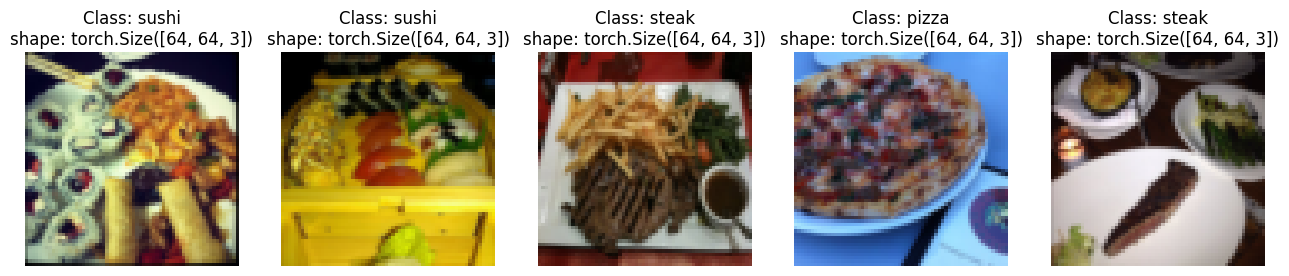

In [146]:
display_random_images(train_data,
                      n=5,
                      classes = class_names,
                      seed = None)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


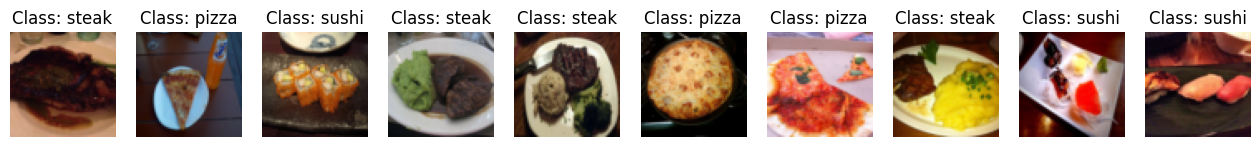

In [148]:
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`

In [153]:
from torch.utils.data import DataLoader
BATCH_SIZE =1
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size= BATCH_SIZE,
                                     num_workers= os.cpu_count(),
                                     shuffle= True)

test_dataloader_custom = DataLoader(dataset= test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle= False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f45146a4460>,
 <torch.utils.data.dataloader.DataLoader at 0x7f45146a5810>)

In [154]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)

In [156]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [157]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg')]

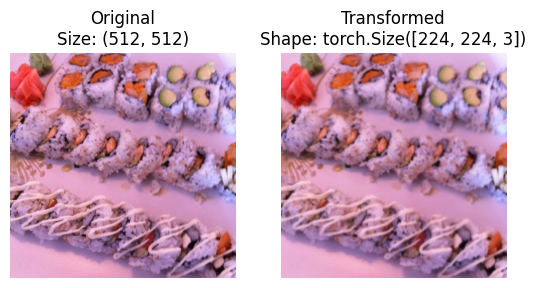

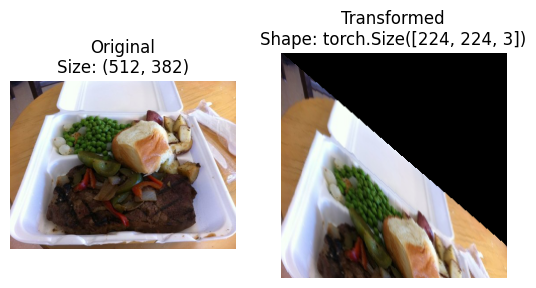

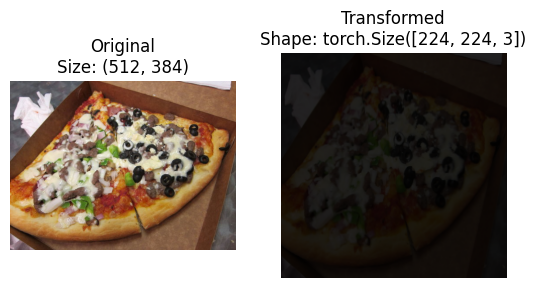

In [158]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n=3,
    seed = None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [161]:
simple_transform = transforms.Compose([
    transforms.Resize(size= (64,64)),
    transforms.ToTensor()
])

In [163]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                         transform=simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset= train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle = True,
                                     num_workers= NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle= False,
                                    num_workers= NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [201]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [202]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [203]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [204]:
model_0(image_batch.to(device))

tensor([[ 1.9746e-02, -8.5213e-04,  9.2906e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.4292e-02, -4.2148e-03,  9.1331e-03],
        [ 2.0417e-02,  2.2111e-03,  4.6835e-03],
        [ 2.1785e-02, -1.5947e-03,  1.0396e-02],
        [ 2.1998e-02, -1.4245e-03,  7.8606e-03],
        [ 2.0893e-02,  1.3043e-04,  8.4190e-03],
        [ 2.4599e-02, -3.2342e-03,  8.6987e-03],
        [ 2.1166e-02, -2.1318e-03,  1.1052e-02],
        [ 2.1689e-02, -2.3871e-03,  7.6426e-03],
        [ 2.0783e-02,  2.1740e-04,  7.7584e-03],
        [ 2.2967e-02, -3.0512e-03,  4.7112e-03],
        [ 2.1135e-02, -1.8134e-03,  8.2606e-03],
        [ 1.9636e-02, -2.5846e-03,  1.1460e-02],
        [ 1.8532e-02, -1.8265e-03,  9.5389e-03],
        [ 2.0214e-02,  4.2893e-04,  1.0943e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 2.1395e-02, -1.9759e-03,  1.2480e-02],
        [ 2.0335e-02, -2.7781e-03,  9.1039e-03],
        [ 1.8239e-02, -2.4790e-04,  7.6190e-03],
        [ 2.1239e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [205]:
!pip install torchinfo

In [206]:
import torchinfo
from torchinfo import summary
summary(model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## 7.5 Create train and test loops functions

In [207]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):

    model.train()

    train_loss, train_acc = 0,0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [208]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    model.eval()
    test_loss, test_acc = 0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss+= loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

    test_loss/= len(dataloader)
    test_acc/=len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [209]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model= model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer,
                                           device = device)
        test_loss ,test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn=loss_fn,
                                        device = device)

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### 7.7 Train and evaluate model 0

In [210]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_result = train(model= model_0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader = test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn = loss_fn,
                       epochs = NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0987 | Train acc: 0.3633 | Test loss: 1.1061 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0972 | Train acc: 0.4297 | Test loss: 1.1286 | Test acc: 0.2812
Epoch: 2 | Train loss: 1.0839 | Train acc: 0.3945 | Test loss: 1.0846 | Test acc: 0.2917
Epoch: 3 | Train loss: 1.0580 | Train acc: 0.5078 | Test loss: 1.0425 | Test acc: 0.3504
Epoch: 4 | Train loss: 1.0196 | Train acc: 0.5547 | Test loss: 1.0343 | Test acc: 0.3731
Total training time: 61.992 seconds


In [212]:
model_0_result

{'train_loss': [1.0987297296524048,
  1.097223848104477,
  1.0839175581932068,
  1.0580284893512726,
  1.019585981965065],
 'train_acc': [0.36328125, 0.4296875, 0.39453125, 0.5078125, 0.5546875],
 'test_loss': [1.1061225334803264,
  1.1286239226659138,
  1.084605097770691,
  1.0424697796503704,
  1.0343358516693115],
 'test_acc': [0.2604166666666667,
  0.28125,
  0.2916666666666667,
  0.3503787878787879,
  0.3731060606060606]}

### 7.8 Plot the loss curves of Model 0

In [214]:
model_0_result.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [218]:
def plot_loss_curves(results : Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

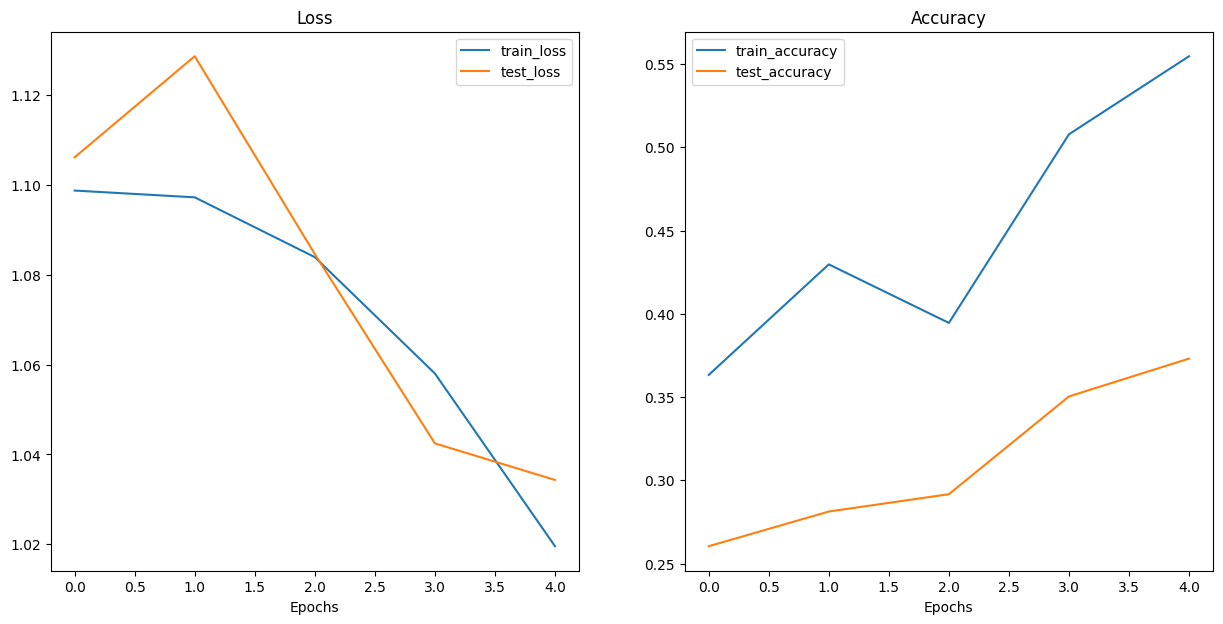

In [219]:
plot_loss_curves(model_0_result)

## 8. What should an ideal loss curve look like?

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [224]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset` and `DataLoader` with data augmentation

In [226]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform_simple)

In [227]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size= BATCH_SIZE,
                                        shuffle = True,
                                        num_workers= NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

In [229]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [236]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.001)

from timeit import default_timer as timer

start_time = timer()

model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0534 | Train acc: 0.5195 | Test loss: 1.0931 | Test acc: 0.2708
Epoch: 1 | Train loss: 1.0546 | Train acc: 0.4727 | Test loss: 1.1092 | Test acc: 0.3125
Epoch: 2 | Train loss: 1.0434 | Train acc: 0.4453 | Test loss: 1.0196 | Test acc: 0.4422
Epoch: 3 | Train loss: 1.0327 | Train acc: 0.4102 | Test loss: 1.0246 | Test acc: 0.4422
Epoch: 4 | Train loss: 0.9773 | Train acc: 0.4805 | Test loss: 1.0818 | Test acc: 0.3021
Total training time: 62.650 seconds


In [231]:
!nvidia-smi

Sat Jan  6 15:32:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:1D:00.0 Off |                  N/A |
| 33%   46C    P2              113W / 350W|   1715MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 9.4 Plot the loss curves of model 1

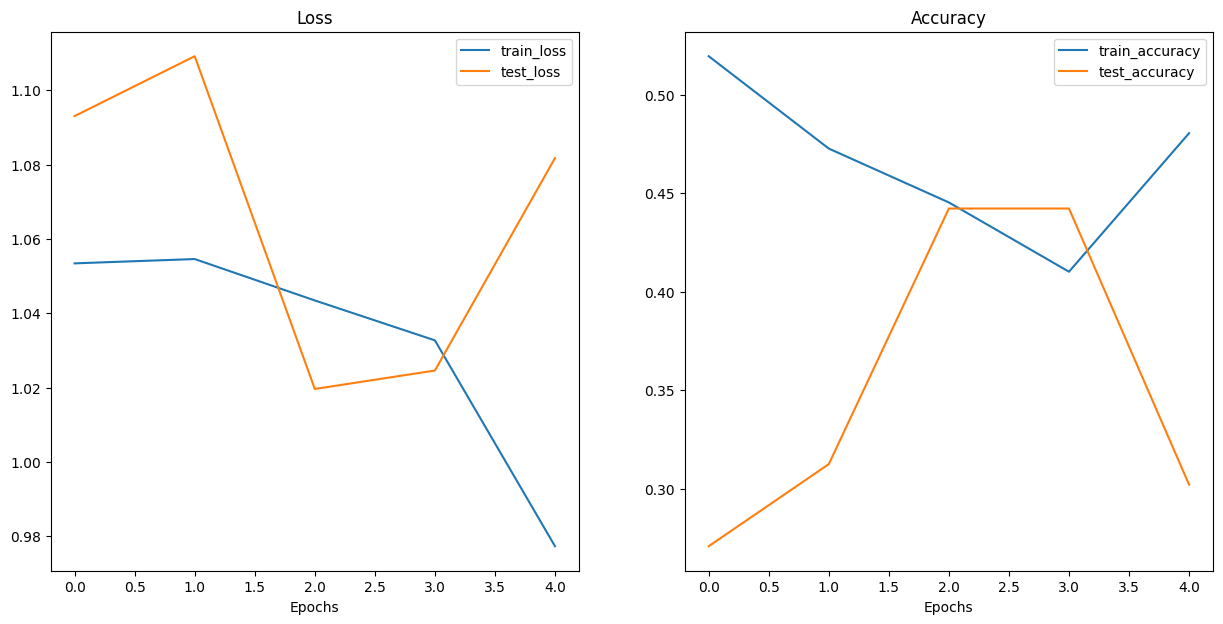

In [238]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [241]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_result)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.098730,0.363281,1.106123,0.260417
1,1.097224,0.429688,1.128624,0.281250
2,1.083918,0.394531,1.084605,0.291667
3,1.058028,0.507812,1.042470,0.350379
4,1.019586,0.554688,1.034336,0.373106


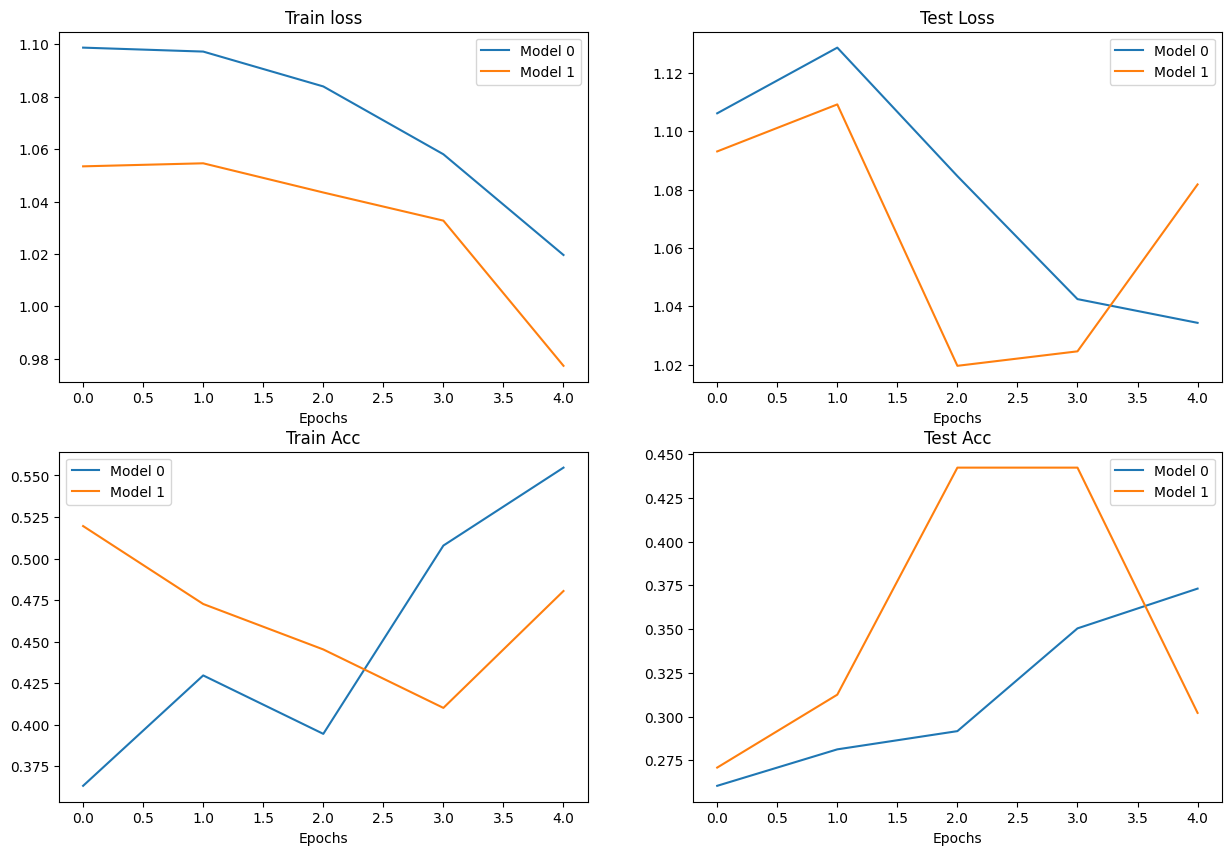

In [246]:
plt.figure(figsize = (15,10))

epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

In [256]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)

else:
    print(f"{custom_image_path} already exists, skipping download...")

### 11. 1 Loading in a custom image with Pytorch

In [258]:
import torchvision

custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
custom_image_unit8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

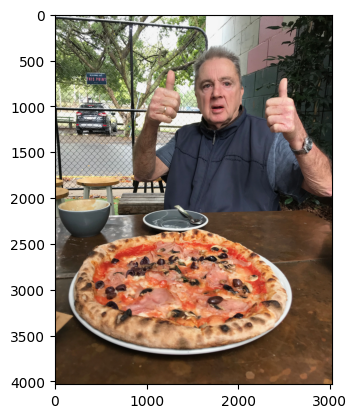

In [259]:
plt.imshow(custom_image_unit8.permute(1,2,0))

## 11.2 Making prediction on a custom image with a trained Pytorch model

In [265]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.

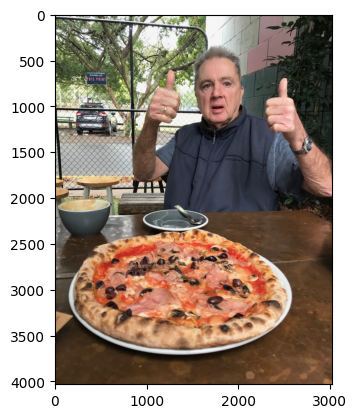

In [266]:
plt.imshow(custom_image.permute(1,2,0))

In [268]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size = (64,64))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


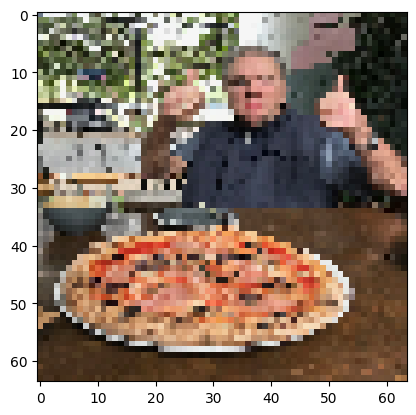

In [269]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [271]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [272]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [276]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.2915, -0.4586, -0.3662]], device='cuda:0')

In [277]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.5024, 0.2373, 0.2603]], device='cuda:0')

In [280]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim =1).cpu()
custom_image_pred_labels

tensor([0])

In [281]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together : building a function

In [286]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    target_image = target_image/255.

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(0)

        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim = 1)

    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

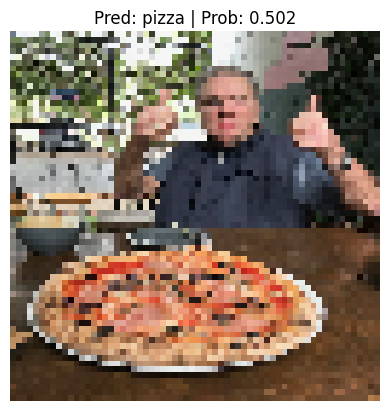

In [289]:
pred_and_plot_image(model = model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform = custom_image_transform,
                    device = device)

In [290]:
!nvidia-smi

Sat Jan  6 16:24:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:1D:00.0 Off |                  N/A |
| 31%   39C    P8               35W / 350W|   2927MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--